# AIBS(hIVSCC-MET/hIVSCC-METx/hIVSCC-METc)

##### Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.9)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths

In [2]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "rna_plot/AIBS/")
path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")

##### Filtering shiny dataframe

In [3]:
fields_shiny = ["cell_name", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score"}

collaborator_dict = {"PG" : "Gabor", "PH" : "Mansvelder"}
for collab in ["P1", "P2", "P6", "P7", "P8", "P9", "PA", "PB", "PE", "PF", "PX", "P3", "P0", "P5"]:
    collaborator_dict[collab] = "AIBS"

In [4]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)

shiny_human["NMS Pass/Fail"] = shiny_human["NMS Pass/Fail"].replace({True: "Pass", False: "Fail"}) #Changing to keep same format
shiny_human["RNA Amp Pass/Fail"] = shiny_human["RNA Amp Pass/Fail"].replace({"Pass": "RNA Amp Pass", "Fail": "RNA Amp Fail"})

INFO:functions.temp_funcs:Read file in as a pandas dataframe


In [5]:
shiny_human = create_container_df(shiny_human, "sample_id") #Create "P1"
shiny_human["collaborator_label"] = shiny_human["collaborator_label"].replace(collaborator_dict) #3592 rows
shiny_aibs = filter_df(shiny_human, "collaborator_label", "AIBS") 

shiny_aibs.dropna(subset=["NMS score", "Seurat prediction score", "cell_specimen_project"], inplace=True)
shiny_aibs.drop(columns=["cDNA quality (%>400 bp)", "Amplified content (ng)"], inplace=True) #2522 rows

INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == AIBS
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\kumar\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
shiny_aibs["cell_specimen_project"].unique()

array(['hIVSCC-MET', 'H301x', 'hMPATCH', 'H301', 'hIVSCC-METx',
       'hIVSCC-METc', 'APL401Ax', 'qIVSCC-METa', 'qIVSCC-METc'],
      dtype=object)

In [7]:
shiny_aibs = shiny_aibs[(shiny_aibs["cell_specimen_project"] ==  "hIVSCC-MET") | \
                        (shiny_aibs["cell_specimen_project"] ==  "hIVSCC-METx") | \
                        (shiny_aibs["cell_specimen_project"] ==  "hIVSCC-METc")] #1645 rows if only x, 1963 if c included

##### Creating count_rn for countplot

In [8]:
shinyh_npass = filter_df(shiny_aibs, "NMS Pass/Fail", "Pass")
shinyh_nfail = filter_df(shiny_aibs, "NMS Pass/Fail", "Fail")
shinyh_rpass = filter_df(shiny_aibs, "RNA Amp Pass/Fail", "RNA Amp Pass")
shinyh_rfail = filter_df(shiny_aibs, "RNA Amp Pass/Fail", "RNA Amp Fail")

INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on RNA Amp Pass/Fail == RNA Amp Pass
INFO:functions.temp_funcs:Filtered dataframe based on RNA Amp Pass/Fail == RNA Amp Fail


In [9]:
rfail_nfail = filter_df(shinyh_rfail, "NMS Pass/Fail", "Fail")
rfail_npass = filter_df(shinyh_rfail, "NMS Pass/Fail", "Pass")
rpass_nfail = filter_df(shinyh_rpass, "NMS Pass/Fail", "Fail")
rpass_npass = filter_df(shinyh_rpass, "NMS Pass/Fail", "Pass")

INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass


In [10]:
rfail_nfail["Group"] = "RNA Amp Fail/NMS Fail"
rfail_npass["Group"] = "RNA Amp Fail/NMS Pass"
rpass_nfail["Group"] = "RNA Amp Pass/NMS Fail"
rpass_npass["Group"] = "RNA Amp Pass/NMS Pass"

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [11]:
count_rn = pd.concat([rfail_nfail, rfail_npass, rpass_nfail, rpass_npass])

count_rn.drop(columns=["sample_id", "RNA Amp Pass/Fail", "NMS score", "NMS Pass/Fail",
                       "Seurat prediction score", "collaborator_label"], inplace=True)

count_rn["Group_count"] = count_rn.groupby(["Group", "Tree_call"])["Tree_call"].transform("count")
count_rn["Group_total"] = count_rn.groupby("Group")["Tree_call"].transform("count")
count_rn["proportion"] = count_rn["Group_count"] / count_rn["Group_total"]

new_piv = pd.pivot_table(count_rn, values='proportion', index=["Group"], columns="Tree_call", fill_value=0)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [12]:
new_piv

Tree_call,Core,I1,I2,I3,PoorQ
Group,,,,,
RNA Amp Fail/NMS Fail,0.000000,0.000000,0.000000,0.000000,1.000000
RNA Amp Fail/NMS Pass,0.088496,0.026549,0.053097,0.017699,0.814159
RNA Amp Pass/NMS Fail,0.008696,0.000000,0.004348,0.000000,0.986957
RNA Amp Pass/NMS Pass,0.440845,0.228873,0.170423,0.007042,0.152817


##### Plot Colors

In [13]:
pf_colors={"Pass": "#41ab5d", "Fail": "#ef3b2c"}
tree_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

##### FacetGrid Plots

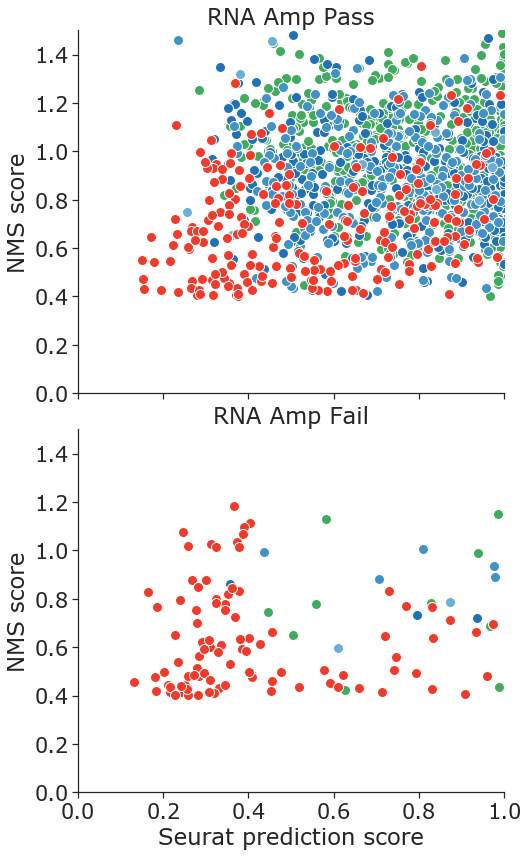

In [14]:
g = sns.FacetGrid(data=shinyh_npass, row="RNA Amp Pass/Fail", height=6, aspect=1.2,
                  hue="Tree_call", hue_order=tree_colors, palette=tree_colors)
g = g.map(plt.scatter, "Seurat prediction score", "NMS score", edgecolor="w", s=100)
g.set_titles("{row_name}")         
g.fig.subplots_adjust(wspace=0.05, hspace=0.1)

plt.xlim(0, 1)
plt.ylim(0, 1.5)
plt.savefig(plot_path + "AIBS_facplot_rna_pass_fail_nms_pass.jpeg", bbox_inches="tight")

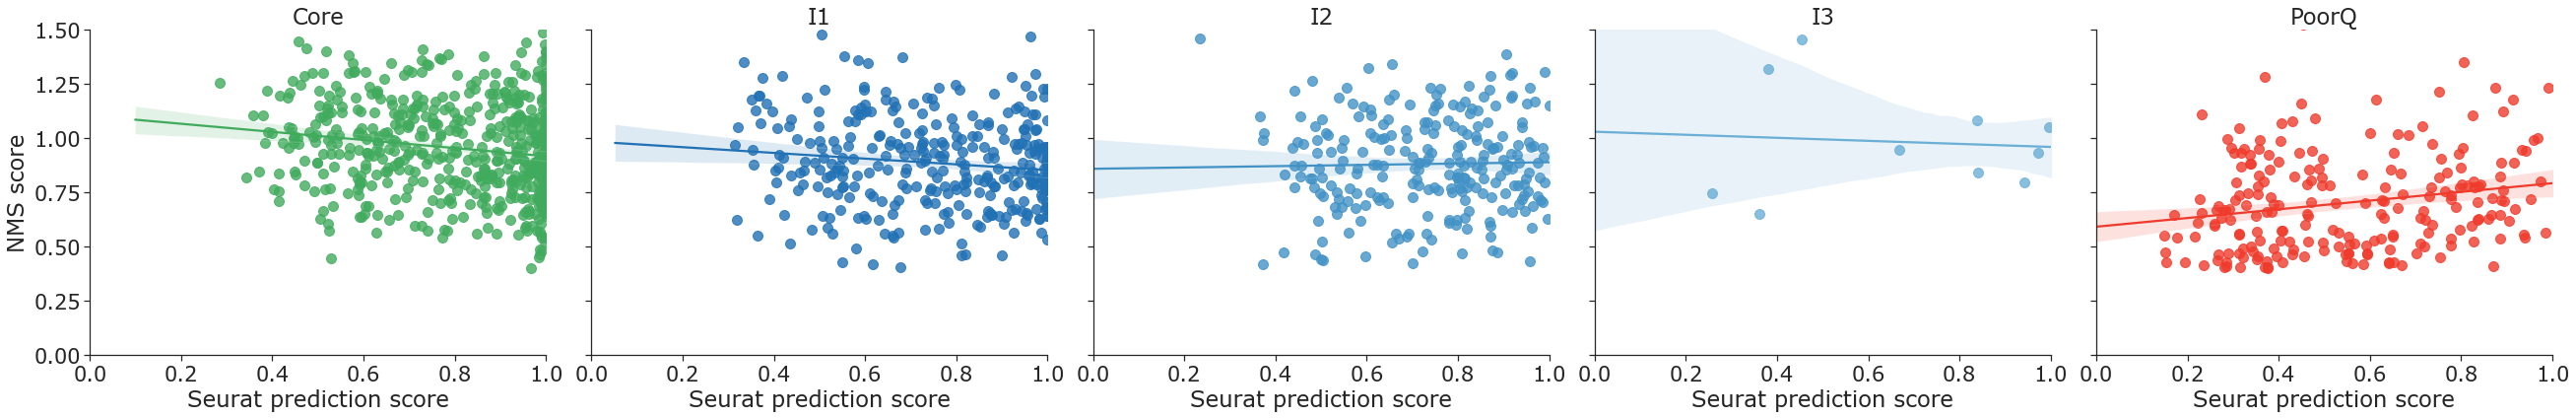

In [15]:
g = sns.lmplot(x="Seurat prediction score", y="NMS score", data=rpass_npass,
               col="Tree_call", hue="Tree_call", col_order=tree_colors, 
               height=6, aspect=1.2, palette=tree_colors, scatter_kws={"s": 100})
g.set_titles("{col_name}")
g.fig.subplots_adjust(wspace=0.10)

plt.xlim(0, 1)
plt.ylim(0, 1.5)
plt.savefig(plot_path + "AIBS_lmplot_rna_pass_nms_pass.jpeg", bbox_inches="tight")

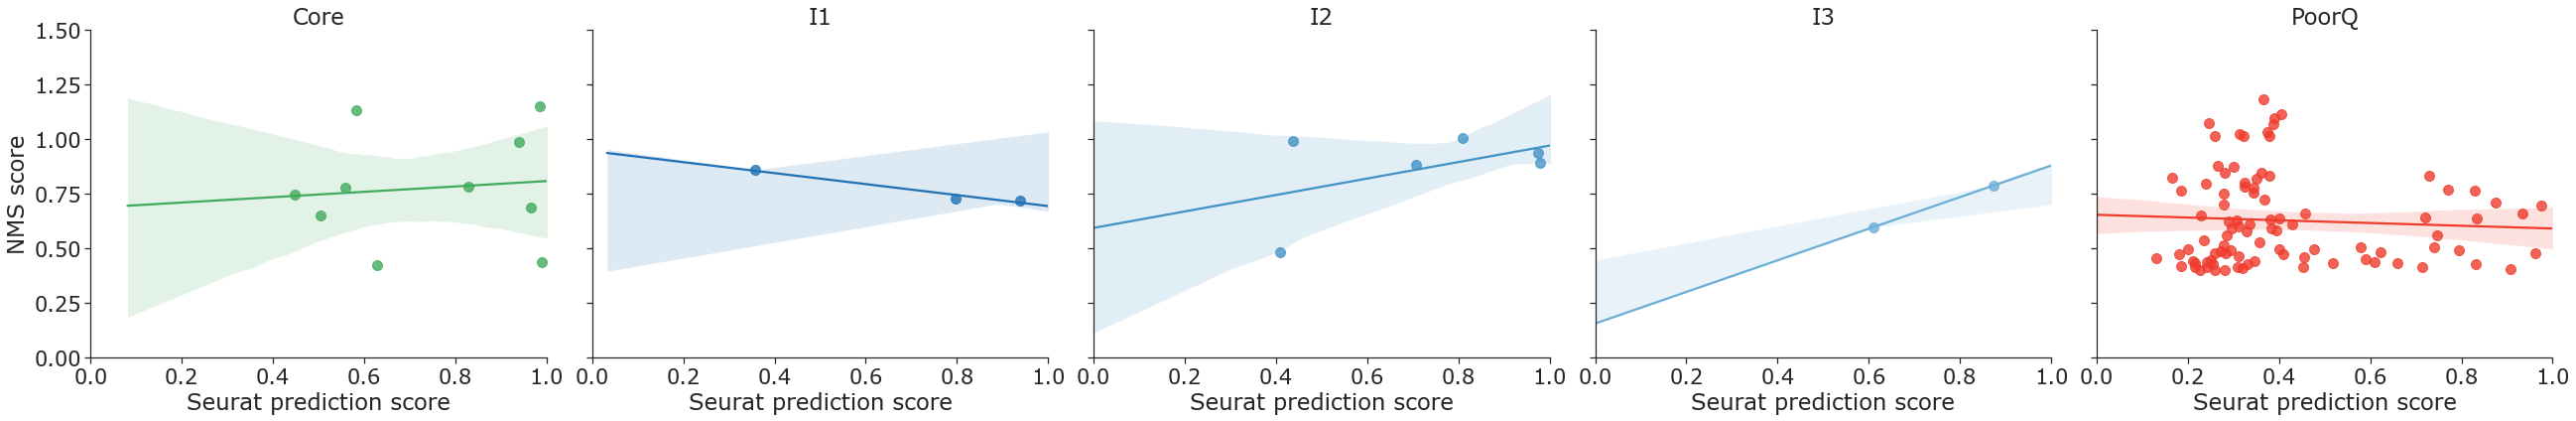

In [16]:
g = sns.lmplot(x="Seurat prediction score", y="NMS score", data=rfail_npass,
               col="Tree_call", hue="Tree_call", col_order=tree_colors, 
               height=6, aspect=1.2, palette=tree_colors, scatter_kws={"s": 100})
g.set_titles("{col_name}")
g.fig.subplots_adjust(wspace=0.10)

plt.xlim(0, 1)
plt.ylim(0, 1.5)
plt.savefig(plot_path + "AIBS_lmplot_rna_fail_nms_pass.jpeg", bbox_inches="tight")

##### Countplot: RNA/NMS Groups

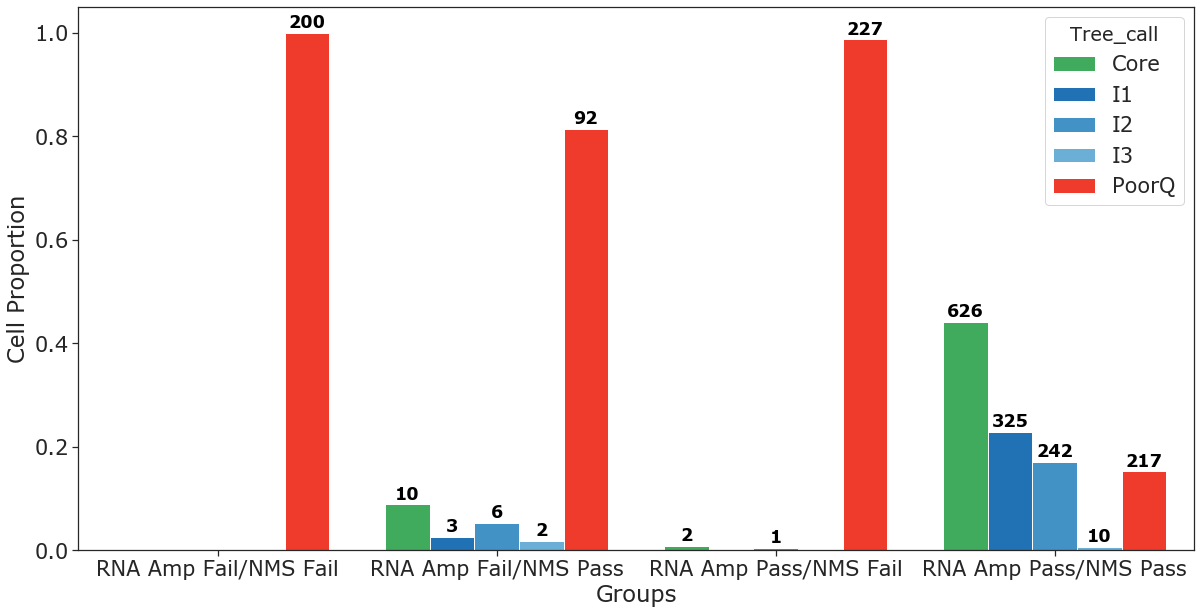

In [17]:
fig_dims = (20, 10)
f, axes = plt.subplots(figsize=fig_dims)

ax = sns.barplot(x="Group", y="proportion", data=count_rn, 
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors, saturation=1)
ax.set(xlabel="Groups", ylabel="Cell Proportion")
plt.xticks(rotation=0)


core = [0, 10, 2, 626]
i1 = [0, 3, 0, 325]
i2 = [0, 6, 1, 242]
i3 = [0, 2, 0, 10]
poorq = [200, 92, 227, 217]
count_list = core + i1 + i2 + i3 + poorq

i=0
for p in ax.patches:
    top_rect = p.get_height() + 0.01
    mid_rect = p.get_x() + p.get_width()/2
    label_rect = count_list[i]
    ax.text(mid_rect, top_rect, label_rect,
            ha="center", size="xx-large", color='black', weight='bold')
    i += 1

plt.savefig(plot_path + "Gabor_countplot_rna_groups.jpeg", bbox_inches="tight")